# 이미지에서 특징 감지하기

## 합성곱 신경망 만들기

In [1]:
import tensorflow as tf

## 말과 사람을 구별하는 CNN 만들기

### 이미지 데이터 준비
    - 라벨은 없이 말과 사람 이미지를 다운받아서, 말은 horse 디렉터리에 사람은 human디렉터리에 저장해 놓음
    
## 케라스 ImageDataGenerator
1. image 디렉터리를 지정하면 자동으로 라벨을 생성해주는 클래스
    - 위 내용으로 준비된 디렉터리의 경로를 알려주면 
        - 디렉터리와 이미지를 모니터링 한 후 디렉터리내에 들어 있는 이미지에 대해서는 동일한 라벨을 생성함
        - ex. horse 디렉터리안의 이미지들은 horse라는 타겟값을 생성해 줌
2. 이미지 증식 및 이미지 변환 작업도 진행

### 이미지 데이터 준비
- 분류시 동일 분류의 이미지는 같은 폴더에 저장 해야 함
- 구글 api가 제공하는 horse-or-human.zip을 사용

In [2]:
import urllib.request  # api 요청 패키지
import zipfile  # 압축파일 관련 라이브러리

In [3]:
# 한번 실행하면 다운 완료되므로 재실행 할 필요 없음
# 구글이 제공하는 이미지셋 활용
url = "https://storage.googleapis.com/learning-datasets/horse-or-human.zip"
file_name = "horse-or-human.zip"
training_dir = 'horse-or-human/training/'
urllib.request.urlretrieve(url, file_name) # 이미지셋 다운로드

('horse-or-human.zip', <http.client.HTTPMessage at 0x7f63971c73a0>)

In [4]:
zip_ref = zipfile.ZipFile(file_name, 'r')  # 압축객체 생성
zip_ref.extractall(training_dir)  # 압축풀기
zip_ref.close()  # 객체 삭제

In [5]:
training_dir = 'horse-or-human/training/'

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')

In [7]:
# 전체 이미지를 1./255로 스케일을 조정합니다.
train_datagen = ImageDataGenerator(rescale=1/255)

# gen 객체를 활용해서 이미지 픽셀 값 조정, 이미지 크기 300*300
# 타겟 라벨도 생성
train_generator = train_datagen.flow_from_directory(
    training_dir, # 학습 이미지가 있는 디렉터리 경로
    target_size=(300,300),
    class_mode= 'binary'
)  # 학습데이터(학습데이터/타겟데이터)
# (이미지크기 300*300)

Found 1027 images belonging to 2 classes.


### 말-사람 데이터셋을 위한 CNN 구조

In [8]:
# 모델 생성(입력층 - 합성곱4개층-평탄화-신경망층-출력층)
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                              input_shape=(300,300,3)), # 합성곱층
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'
                              ), # 합성곱층
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'
                              ), # 합성곱층
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'
                              ), # 합성곱층
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'
                              ), # 합성곱층
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

# 층이 정해져있지는 않음 보통 입력층-합성곱층(원하는만큼)-flatten-출력층에 신경망층

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

### CNN 모델의 층 구성
- 층의 수가  정해져있지는 않음 
- 보통 입력층-합성곱층(원하는만큼)-flatten-밀집층-규제-밀집출력층
- 합성곱층의 필터 수는 
    - 16부터 시작해서 또는 16의 배수로 시작 뒤의 층으로 갈수로 16의 배수만큼 늘리는게 일반적
        - 16, 32, 64, 128 순으로 필터수를 결정
- 층을 변경해서 가장 적합한 모델을 만드는것이 합성곱 또는 신경망계열 알고리즘의 튜닝

In [10]:
from tensorflow.keras.optimizers import RMSprop  # 이미지에 최적화

In [11]:
# 이진분류 compile 코드 
model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['accuracy']) 

# 컬러 이미지 치고 해상도가 낮고 크기도 작은 이미지를 학습할것임
# 학습률을 줄여서 최적점을 찾음

In [12]:
# 모델 학습 (에포크 기본 15번)
# 학습 데이터 (generator 데이터)는 객체변수 사용
model.fit(train_generator, epochs=15)

Epoch 1/15
33/33 [==============================] - 14s 279ms/step - loss: 0.7826 - accuracy: 0.6047
Epoch 2/15
33/33 [==============================] - 6s 199ms/step - loss: 0.4425 - accuracy: 0.8413
Epoch 3/15
33/33 [==============================] - 6s 194ms/step - loss: 0.1810 - accuracy: 0.9309
Epoch 4/15
33/33 [==============================] - 6s 194ms/step - loss: 0.1381 - accuracy: 0.9542
Epoch 5/15
33/33 [==============================] - 7s 195ms/step - loss: 0.0919 - accuracy: 0.9698
Epoch 6/15
33/33 [==============================] - 7s 196ms/step - loss: 0.0479 - accuracy: 0.9854
Epoch 7/15
33/33 [==============================] - 6s 193ms/step - loss: 0.2365 - accuracy: 0.9718
Epoch 8/15
33/33 [==============================] - 6s 194ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 9/15
33/33 [==============================] - 6s 194ms/step - loss: 3.0772e-04 - accuracy: 1.0000
Epoch 10/15
33/33 [==============================] - 6s 200ms/step - loss: 1.0320e-04 - accurac

## `image_dataset_from_directory` 사용하기

- 기본 파라미터
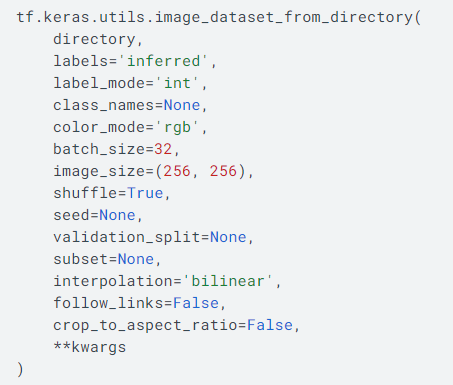

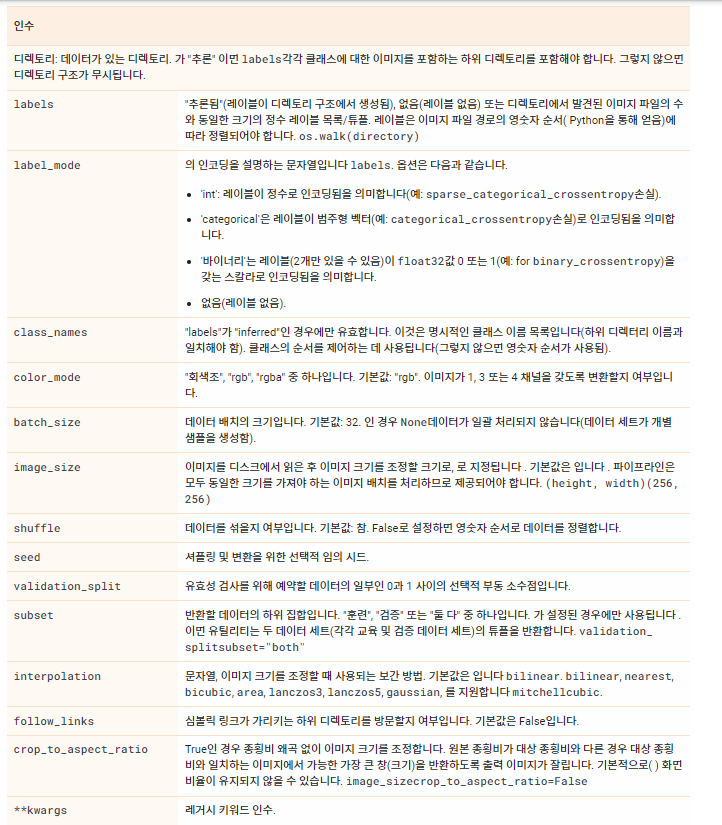

### image_dataset_from_directory vs flow_from_directory
- 포함 라이브러리가 다름
- tf.keras.preprocessing.image_dataset_from_directory
    - 디렉터리의 이미지 파일에서 tf.data.Dataset을 생성합니다 .
- ImageDataGenerator.flow_from_directory
    - 디렉터리에 대한 경로를 가져오고 증강 데이터 배치를 생성합니다 .
    - 이미지 증식이 가능함

In [13]:
# dataset 반환(train_df는 학습/타겟 데이터 저장)
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    image_size=(300, 300),
    label_mode='binary'
) 

Found 1027 files belonging to 2 classes.


In [14]:
model = tf.keras.models.Sequential([
    # input층 생성시 이미지 전처리를 진행하게 설정
    tf.keras.layers.Rescaling(1./255, input_shape=(300, 300, 3)), 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [15]:
# model에 rescaling층이 있어서 모델에 이미지 주입되면 rescale 진행 후 학습

model.fit(train_ds, epochs=15) # train_ds는 전처리 되지 않은 이미지 데이터가 주입

Epoch 1/15
33/33 [==============================] - 4s 55ms/step - loss: 0.7887 - accuracy: 0.6066
Epoch 2/15
33/33 [==============================] - 2s 56ms/step - loss: 0.5000 - accuracy: 0.7722
Epoch 3/15
33/33 [==============================] - 2s 56ms/step - loss: 0.2740 - accuracy: 0.8929
Epoch 4/15
33/33 [==============================] - 2s 56ms/step - loss: 0.1783 - accuracy: 0.9367
Epoch 5/15
33/33 [==============================] - 2s 55ms/step - loss: 0.1906 - accuracy: 0.9377
Epoch 6/15
33/33 [==============================] - 2s 56ms/step - loss: 0.1044 - accuracy: 0.9611
Epoch 7/15
33/33 [==============================] - 2s 56ms/step - loss: 0.0392 - accuracy: 0.9844
Epoch 8/15
33/33 [==============================] - 2s 56ms/step - loss: 0.2144 - accuracy: 0.9513
Epoch 9/15
33/33 [==============================] - 2s 56ms/step - loss: 0.0269 - accuracy: 0.9903
Epoch 10/15
33/33 [==============================] - 2s 55ms/step - loss: 0.2164 - accuracy: 0.9688
Epoch 11/

### 검증 세트 추가하기

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [18]:
# 검증데이터 다운로드
validation_url = "https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip"

validation_file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
urllib.request.urlretrieve(validation_url, validation_file_name)

zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

In [19]:
# 검증데이터 전처리
val_datagen = ImageDataGenerator(rescale=1/255)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(300,300),
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


## ImageDataGenerator의 결과 확인

In [20]:
# for x_data, y_data in val_generator :
#     print(x_data.shape)
#     print(type(x_data))
#     print(y_data)
#     print(x_data)

In [21]:
model.fit(train_generator,
          epochs=15,
          validation_data=val_generator)

Epoch 1/15
33/33 [==============================] - 9s 229ms/step - loss: 0.6858 - accuracy: 0.6602 - val_loss: 0.7025 - val_accuracy: 0.8359
Epoch 2/15
33/33 [==============================] - 7s 225ms/step - loss: 0.3294 - accuracy: 0.8734 - val_loss: 1.9526 - val_accuracy: 0.7617
Epoch 3/15
33/33 [==============================] - 7s 225ms/step - loss: 0.2174 - accuracy: 0.9299 - val_loss: 1.1764 - val_accuracy: 0.8711
Epoch 4/15
33/33 [==============================] - 7s 225ms/step - loss: 0.2339 - accuracy: 0.9377 - val_loss: 1.3683 - val_accuracy: 0.8477
Epoch 5/15
33/33 [==============================] - 7s 224ms/step - loss: 0.0723 - accuracy: 0.9747 - val_loss: 2.8915 - val_accuracy: 0.7812
Epoch 6/15
33/33 [==============================] - 8s 227ms/step - loss: 0.0788 - accuracy: 0.9757 - val_loss: 2.4372 - val_accuracy: 0.7969
Epoch 7/15
33/33 [==============================] - 8s 226ms/step - loss: 0.0955 - accuracy: 0.9679 - val_loss: 1.5645 - val_accuracy: 0.8398
Epoch 

### 모델 실행하기

In [22]:
# 배부된 image 이용해서 모델 활용해보기
import sys
sample_images = ['./image/hh_image_{}.jpg'.format(i) for i in range(1,4)]

In [23]:
sample_images

['./image/hh_image_1.jpg', './image/hh_image_2.jpg', './image/hh_image_3.jpg']

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

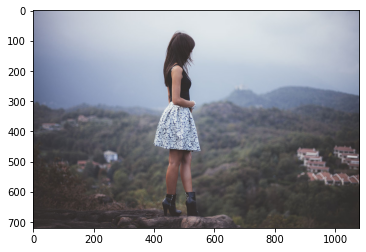

In [25]:
plt.imshow(mpimg.imread(sample_images[0]))
plt.show()

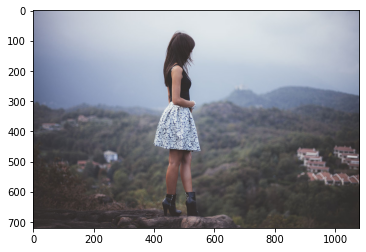

1/1 [==============================] - 0s 253ms/step
모델 출력: 1.0
./image/hh_image_1.jpg는 사람입니다.
--------------------


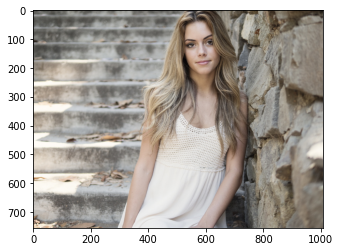

1/1 [==============================] - 0s 23ms/step
모델 출력: 1.0
./image/hh_image_2.jpg는 사람입니다.
--------------------


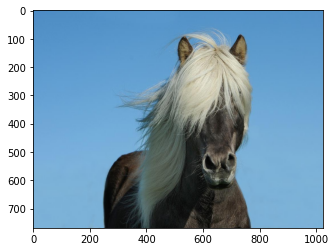

1/1 [==============================] - 0s 22ms/step
모델 출력: 0.0
./image/hh_image_3.jpg는 말입니다.
--------------------


In [26]:
for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(300,300) )
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0) # 3차원 칼라이미지를 4차원 이미지로 변형
    ##(1,300,30,3)
    classes = model.predict(x)

    print('모델 출력:',classes[0][0] )
    if classes[0][0] > 0.5:
        print(fn + "는 사람입니다.")
    else:
        print(fn + "는 말입니다.")
    print('--------------------')

## 이미지 증식

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [29]:
train_datagen = ImageDataGenerator(
   rescale=1./255,
   rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [30]:
model.fit(train_generator,
          epochs=15,
          validation_data=val_generator)

Epoch 1/15
33/33 [==============================] - 24s 678ms/step - loss: 0.7165 - accuracy: 0.5394 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 2/15
33/33 [==============================] - 23s 690ms/step - loss: 0.6753 - accuracy: 0.6271 - val_loss: 0.6975 - val_accuracy: 0.5273
Epoch 3/15
33/33 [==============================] - 23s 685ms/step - loss: 0.5749 - accuracy: 0.7098 - val_loss: 0.8901 - val_accuracy: 0.5039
Epoch 4/15
33/33 [==============================] - 23s 683ms/step - loss: 0.4879 - accuracy: 0.7702 - val_loss: 2.1410 - val_accuracy: 0.5742
Epoch 5/15
33/33 [==============================] - 23s 683ms/step - loss: 0.4667 - accuracy: 0.7965 - val_loss: 1.8090 - val_accuracy: 0.5781
Epoch 6/15
33/33 [==============================] - 23s 681ms/step - loss: 0.4764 - accuracy: 0.8189 - val_loss: 0.5293 - val_accuracy: 0.5977
Epoch 7/15
33/33 [==============================] - 22s 678ms/step - loss: 0.3408 - accuracy: 0.8520 - val_loss: 1.1542 - val_accuracy: 0.7109

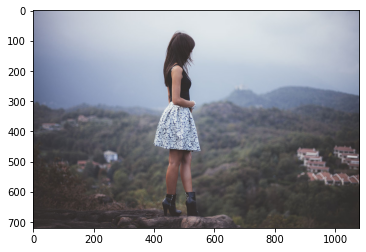

1/1 [==============================] - 0s 83ms/step
모델 출력: 1.0
./image/hh_image_1.jpg는 사람입니다.
--------------------


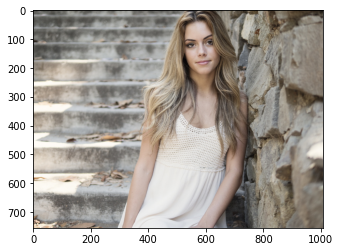

1/1 [==============================] - 0s 22ms/step
모델 출력: 1.0
./image/hh_image_2.jpg는 사람입니다.
--------------------


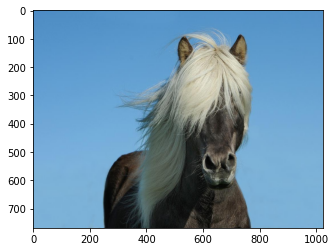

1/1 [==============================] - 0s 22ms/step
모델 출력: 2.6889346e-19
./image/hh_image_3.jpg는 말입니다.
--------------------


In [31]:
for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(300,300) )
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0) # 3차원 칼라이미지를 4차원 이미지로 변형
    ##(1,300,30,3)
    classes = model.predict(x)

    print('모델 출력:',classes[0][0] )
    if classes[0][0] > 0.5:
        print(fn + "는 사람입니다.")
    else:
        print(fn + "는 말입니다.")
    print('--------------------')

### 이미지 변환 예제

In [32]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 이미지 다운로드
!wget https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg

--2023-09-12 02:42:41--  https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg
Resolving www.sciencenews.org (www.sciencenews.org)... 18.65.148.43, 18.65.148.12, 18.65.148.125, ...
Connecting to www.sciencenews.org (www.sciencenews.org)|18.65.148.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61745 (60K) [image/jpeg]
Saving to: ‘033120_HT_covid-cat_feat-1028x579.jpg.1’

033120_HT_covid-cat 100%[===================>]  60.30K  --.-KB/s    in 0.001s  

2023-09-12 02:42:41 (72.9 MB/s) - ‘033120_HT_covid-cat_feat-1028x579.jpg.1’ saved [61745/61745]



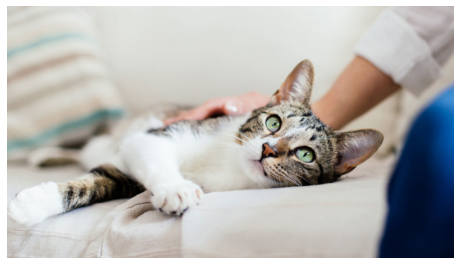

In [33]:
image = cv2.cvtColor(cv2.imread('033120_HT_covid-cat_feat-1028x579.jpg'),
                    cv2.COLOR_BGR2RGB)

def show_image(image) :
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.axis('off')
    
show_image(image)

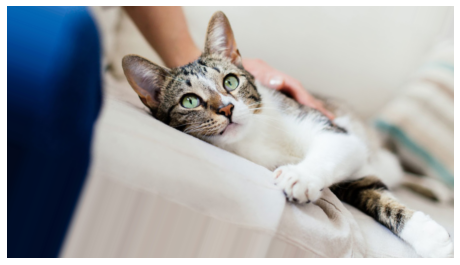

In [34]:
d_gen = ImageDataGenerator(horizontal_flip=True,rotation_range=40)
image_batch = np.expand_dims(image, axis=0)  # 차원확장
d_gen.fit(image_batch)
d_gen_iter = d_gen.flow(image_batch)

# next 함수 이용해 실행
a_batch = next(d_gen_iter)
a_image = np.squeeze(a_batch)

a_image=a_image.astype('int')

show_image(a_image)

#### `image_dataset_from_directory` 사용하기

In [35]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    image_size=(300, 300),
    label_mode='binary'
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(300, 300),
    label_mode='binary'
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(300, 300, 3)),
    tf.keras.layers.RandomRotation(0.11, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs=15,
          validation_data=validation_ds)

Epoch 1/15
33/33 [==============================] - 13s 251ms/step - loss: 0.7085 - accuracy: 0.5433 - val_loss: 0.6754 - val_accuracy: 0.5000
Epoch 2/15
33/33 [==============================] - 8s 240ms/step - loss: 0.6782 - accuracy: 0.6456 - val_loss: 0.6295 - val_accuracy: 0.5000
Epoch 3/15
33/33 [==============================] - 9s 248ms/step - loss: 0.5747 - accuracy: 0.7108 - val_loss: 0.3686 - val_accuracy: 0.8320
Epoch 4/15
33/33 [==============================] - 9s 247ms/step - loss: 0.5036 - accuracy: 0.7488 - val_loss: 0.5902 - val_accuracy: 0.7852
Epoch 5/15
33/33 [==============================] - 9s 249ms/step - loss: 0.4251 - accuracy: 0.8092 - val_loss: 1.8766 - val_accuracy: 0.7383
Epoch 6/15
33/33 [==============================] - 9s 244ms/step - loss: 0.3462 - accuracy: 0.8559 - val_loss: 1.0289 - val_accuracy: 0.7539
Epoch 7/15
33/33 [==============================] - 8s 240ms/step - loss: 0.3797 - accuracy: 0.8559 - val_loss: 1.3534 - val_accuracy: 0.7617
Epoch

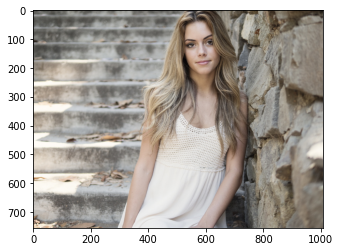

1/1 [==============================] - 0s 89ms/step
모델 출력: 0.868649
./image/hh_image_2.jpg는 사람입니다.


In [37]:
fn = sample_images[1]
plt.imshow(mpimg.imread(fn))
plt.show()

# 이미지 불러오기
img = tf.keras.utils.load_img(fn, target_size=(300, 300))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

classes = model.predict(x)

print('모델 출력:', classes[0][0])
if classes[0][0] > 0.5:
    print(fn + "는 사람입니다.")
else:
    print(fn + "는 말입니다.")